### 霍夫变换实现车道线检测
#### 实现思路
- 彩色图转为灰度图
- 高斯滤波去除噪声
- 边缘检测，使用效果好的canny边缘检测算子
- 霍夫变化直线检测
- 绘制车道线并叠加到原始图像

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

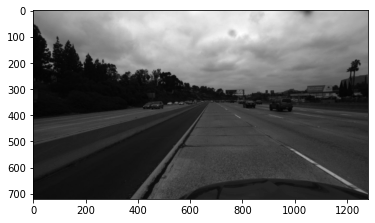

In [2]:
img_src = cv2.imread("LaneLines/test0.jpg")
img_src = cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB)
img_gray = cv2.imread("LaneLines/test0.jpg",cv2.IMREAD_GRAYSCALE) # 以灰度图方式读取
plt.imshow(img_gray,cmap='gray')
plt.show()

### 高斯滤波去噪

In [3]:
def gauss_filter(image, sigma=1, kernel_size=3):
    height, width = image.shape
    out_y = np.zeros((height, width))
    out = np.zeros( (height, width))
    pad = int(kernel_size / 2)

    # 计算x方向高斯核
    kernel_x = np.zeros(kernel_size)
    kernel_x_sum = 0
    for i in range(kernel_size):
        _i = i - pad # 在核空间下的x坐标
        kernel_x[i] = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(_i**2)/(2*(sigma**2))) #根据高斯公式计算
        kernel_x_sum += kernel_x[i] # 累加
    kernel_x_norm = kernel_x / kernel_x_sum

    # 计算y方向高斯核
    kernel_y = np.zeros(kernel_size)
    kernel_y_sum = 0
    for i in range(kernel_size):
        _i = i - pad
        kernel_y[i] = 1 / np.sqrt(2 * np.pi * sigma ** 2) * np.exp(-(_i ** 2) / (2 * (sigma ** 2)))
        kernel_y_sum += kernel_y[i]
    kernel_y_norm = kernel_y / kernel_y_sum

    # 进行y方向滤波
    for x in range(pad, height - pad):
        for y in range(pad, width - pad):
            temp_filter_y = 0
            for dy in range(-pad, pad + 1):
                temp_filter_y += image[x + dy][y] * kernel_y_norm[dy + pad]
            out_y[x][y] = temp_filter_y

    # 在y滤波的基础上进行x方向滤波
    for x in range(pad, height - pad):
        for y in range(pad, width - pad):
            temp_filter_x = 0
            for dx in range(-pad, pad + 1):
                temp_filter_x += out_y[x][y + dx] * kernel_x_norm[dx + pad]
            out[x][y] = temp_filter_x

    return out

In [4]:
img_gauss_filter = gauss_filter(img_gray)

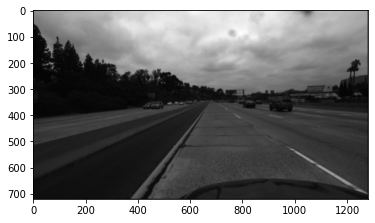

In [5]:
plt.imshow(img_gauss_filter,cmap='gray')
plt.show()

In [6]:
def canny_edge_detection(image, low_threshold, high_threshold):
    # Canny 边缘检测 由于核心目标是霍夫变化的车道线检测因此这里直接调用opencv提供的canny算子
    #确保图像深度为 CV_8U
    img_uint8 = cv2.convertScaleAbs(image)
    edges = cv2.Canny(img_uint8, low_threshold, high_threshold)
    return edges

In [7]:
img_edges = canny_edge_detection(img_gauss_filter,50,150)

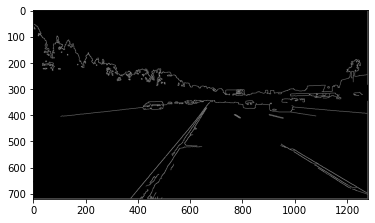

In [8]:
plt.imshow(img_edges,cmap='gray')
plt.show()

### 霍夫变换直线检测
***伪代码***
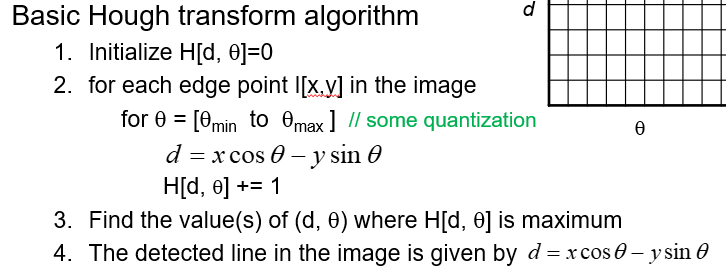

In [9]:
def hough_transform(image, lines_count=20):
    # 实现霍夫变换
    image_shape = image.shape
    D = np.ceil(np.sqrt(image_shape[0] ** 2 + image_shape[1] ** 2))
    d_range = np.arange(0, D + 1)
    # 初始化 Hough 矩阵
    H = np.zeros((len(d_range), 180), dtype=int)
    for y in tqdm(range(image_shape[0])):
        for x in range(image_shape[1]):
            point = image[y, x]
            if point > 0:
                # 是边缘点
                for theta in np.arange(0, 180):
                    rad_theta = np.deg2rad(theta)
                    d = int(x * np.cos(rad_theta) + y * np.sin(rad_theta))  # 注意是加
                    H[d, theta] += 1
    # 非极大值抑制
    for y in range(len(d_range)):
        for x in range(180):
            x1 = max(x-1, 0)
            x2 = min(x+2, 180)
            y1 = max(y-1, 0)
            y2 = min(y+2, len(d_range)-1)
            if np.max(H[y1:y2, x1:x2]) == H[y,x] and H[y, x] != 0:
                pass
                #hough[y,x] = 255
            else:
                H[y,x] = 0

    # 寻找累加器中大于阈值的点
    # 获取前20个最大值的索引
    indices = np.argpartition(H.ravel(), -lines_count)[-lines_count:]
    indices = indices[np.argsort(H.ravel()[indices])][::-1]

    # 获取对应的(d, theta)坐标
    top_lines = [(index // 180, index % 180) for index in indices]
    return top_lines

In [10]:
def draw_lines(img,hough_lines,color=[255,0,0],thickness=2):
    image_with_lines = img.copy()

    for line in tqdm(hough_lines):
        rho, theta = line
        if theta < 60 or theta > 110:
            a = np.cos(np.deg2rad(theta))
            b = np.sin(np.deg2rad(theta))
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 3000 * (-b))
            y1 = int(y0 + 3000 * (a))
            x2 = int(x0 - 3000 * (-b))
            y2 = int(y0 - 3000 * (a))

            # 在图像上绘制直线
            cv2.line(image_with_lines, (x1, y1), (x2, y2), (255,0 , 0), thickness=4)

    return image_with_lines

In [11]:
detected_lines_res = hough_transform(img_edges,18)   

100%|████████████████████████████████████████████████████████████████████████████████| 720/720 [00:13<00:00, 52.55it/s]


In [12]:
detected_lines_res

[(718, 90),
 (1, 90),
 (1278, 0),
 (746, 40),
 (1, 0),
 (413, 84),
 (1399, 122),
 (1412, 121),
 (280, 95),
 (417, 83),
 (0, 119),
 (1404, 122),
 (754, 35),
 (1435, 120),
 (752, 32),
 (756, 33),
 (1421, 121),
 (336, 89)]

In [13]:
img_with_lines = draw_lines(img_src, detected_lines_res)

100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 4504.08it/s]


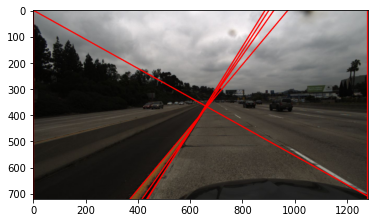

In [14]:
plt.imshow(img_with_lines)
plt.show()

In [15]:
cv2_hough_lines = cv2.HoughLines(img_edges,1,np.pi/180,200)

In [16]:
def draw_lines(img, houghLines, color=[255, 0, 0], thickness=2):
    image_with_lines = img.copy()
    for line in houghLines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            cv2.line(image_with_lines,(x1,y1),(x2,y2),color,thickness)
    return image_with_lines

In [17]:
img_with_lines = draw_lines(img_gray,cv2_hough_lines)

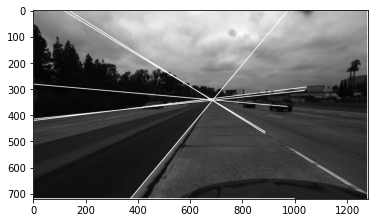

In [18]:
plt.imshow(img_with_lines,cmap='gray')
plt.show()